# Linear Regression Models for Violations Data
We will use the same approach as the violation data, looking only at outside influences and see if we can model the number of daily intersection crashes in Chicago

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [3]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db


In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('rlc_all_hours',), ('daily_covid',), ('holidays',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_o

## Query our data
We will start by making a model to measure changing outside effects on our crashes.  These are weather, traffic, and temporal.  I will do d separate and simpler study of intersection characteristics and how they affect crashes.


I would like to get daily red light camera intersection data with the following columns:
- violations
- weekday
- month
- year
- region   (can add this post query with lambda function from intersection_cams and region_data tables, ugh!)
- congestion (try peak, rush hour, average, etc)
- precipitation
- max_temp

Each intersection should have one entry per day.  Weather will use aggregate daily values.
Congestion will use aggragate also, although I am look for congestion at rush hour as a factor.


In [130]:
# get a df with all relevant data.

int_df = pd.read_sql_query('''
WITH 
    ah AS(
        SELECT *
        FROM rlc_all_hours
        GROUP by year, month, day
        ),

    v as
    (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

ic as
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c as
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT AVG(allcg.min_speed) as min_speed,
            AVG(allcg.speed) as speed,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            AVG(allcg.quantile_speed) as quantile_speed,
            AVG(allcg.avg_congestion) as avg_congestion,

            AVG(rh1.morning_rush_speed) as morning_rush_hour,
            AVG(rh1.morning_rush_quant) as morning_rush_quant ,
            AVG(rh1.morning_rush_congestion) as morning_rush_congestion,
            AVG(rh1.morning_rush_speed) as morning_rush_speed,

            AVG(rh2.afternoon_rush_speed) as afternoon_rush_speed,
            AVG(rh2.afternoon_rush_quant) as afternoon_rush_quant,
            AVG(rh2.afternoon_rush_congestion) as afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id
     
     GROUP BY allcg.year, allcg.month, allcg.day
     ORDER BY allcg.year, allcg.month, allcg.day
),


 wx as
    (SELECT temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year    
     FROM hourly_weather
     GROUP BY year, month, day
    ),
cov as
    (SELECT CAST(cases_total as INT) as cases_total,
            lab_report_date
    FROM daily_covid
            
    ),
hol as
    (SELECT year, month, day, holiday FROM holidays
    )

SELECT  SUM(v.violations) as violations,
        v.year,
        CAST(v.month as INT) as month,
        v.day,

        AVG(c.speed) as speed, 
        CAST(c.quantile_speed as REAL) as quantile_speed,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.avg_congestion) as avg_congestion,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp,
        cov.cases_total,
        AVG(c.morning_rush_speed) as morning_rush_speed,
        hol.holiday

        

FROM v
LEFT JOIN ah
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
LEFT JOIN ic
  ON v.intersection = ic.intersection
LEFT JOIN c
  ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
LEFT JOIN wx
  ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
LEFT JOIN cov
    ON DATE(cov.lab_report_date) = DATE(v.violation_date)
LEFT JOIN hol
    ON hol.year = v.year
    AND hol.month = v.month
    AND hol.day = v.day

    
WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

                                    ''', conn)

# LOOKS GOOD!!
print(int_df.info())
int_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 19 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null float64
temp                         1217 non-null float64
cases_total                  305 non-null float64
morning_rush_speed           1187 non

,violations,year,month,day,speed,quantile_speed,min_speed,avg_congestion,morning_rush_quant,morning_rush_congestion,afternoon_rush_speed,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp,cases_total,morning_rush_speed,holiday
0,1704,2017,9,1,24.150353,39.575660,19.306782,60.424340,12.820329,0.871797,20.869598,10.065892,0.899341,4,0.00,294.15,NaN,23.075891,None
1,1623,2017,9,2,25.115606,49.437830,21.337644,50.562170,46.627070,0.533729,22.993506,23.600817,0.763992,5,0.00,292.15,NaN,26.325906,None
2,1494,2017,9,3,26.002740,60.754535,22.096494,39.245465,58.017443,0.419826,24.317931,41.146516,0.588535,6,6.60,295.15,NaN,27.089282,None
3,1258,2017,9,4,25.515766,54.635059,23.222586,45.364941,58.417261,0.415827,24.023103,36.393470,0.636065,0,1.12,300.15,NaN,26.765173,Labor Day
4,1366,2017,9,5,24.122026,39.798663,19.216897,60.201337,11.788381,0.882116,20.264483,5.074259,0.949257,1,0.00,297.15,NaN,22.672759,None


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [131]:
int_df['holiday'] = int_df.holiday.notnull()
int_df.cases_total.fillna(0, inplace=True)
int_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 19 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null float64
temp                         1217 non-null float64
cases_total                  1217 non-null float64
morning_rush_speed           1187 no

In [132]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [133]:
int_df.dropna(inplace=True)

In [134]:
# Change weekday to string
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
int_df['weekday'] = int_df['weekday'].apply(lambda x: days_of_week[x])

months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

int_df['month'] = int_df['month'].apply(lambda x: months[x-1])


In [135]:
int_df.columns

Index(['violations', 'year', 'month', 'day', 'speed', 'quantile_speed',
       'min_speed', 'avg_congestion', 'morning_rush_quant',
       'morning_rush_congestion', 'afternoon_rush_speed',
       'afternoon_rush_quant', 'afternoon_rush_congestion', 'weekday',
       'precip', 'temp', 'cases_total', 'morning_rush_speed', 'holiday'],
      dtype='object')

In [136]:
# Lets look at some regressions for all of my chosen columns



# Eliminated and useful features
target = 'violations'
drop_me = ['day', 'min_speed', 'speed', 'quantile_speed', 'month',
          'afternoon_rush_speed', 'morning_rush_speed', 'year', 'afternoon_rush_congestion',
          'morning_rush_congestion', 'morning_rush_quant', 'afternoon_rush_quant', 'cases_total',
          'avg_congestion']
categoricals = ['weekday', 'holiday']

df_cont = int_df.copy()
df_cont.drop(columns=drop_me+categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    #fig, axes = plt.subplots(figsize=(15,12))
    #fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    #fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    #fig.tight_layout()
    #plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.014e+32
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:08:23   Log-Likelihood:                 30846.
No. Observations:                1182   AIC:                        -6.169e+04
Df Residuals:                    1180   BIC:                        -6.168e

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,precip,0.016391,1.507725e+03,-3.315640,1.009767e-05,17.878072
2,temp,0.440710,-3.974151e+03,19.075055,4.459325e-151,86.978550
0,violations,1.000000,1.136868e-13,1.000000,0.000000e+00,83.449980


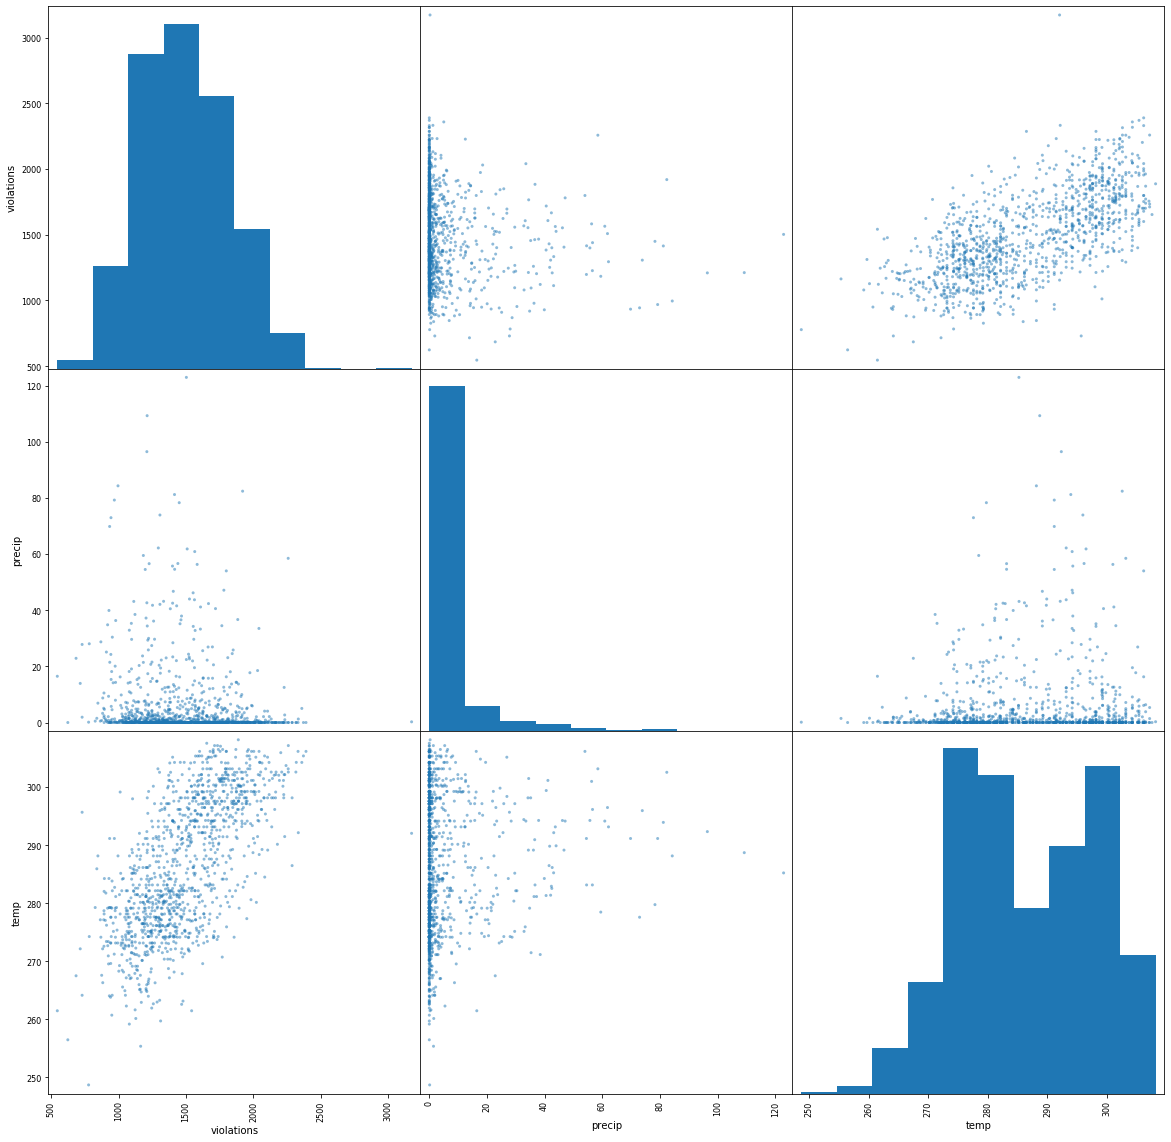

In [137]:
# scatter plot takes a few min
pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
plt.show()

In [138]:
df_cont.corr()  # create a correlation matrix

,violations,precip,temp
violations,1.000000,-0.128026,0.66386
precip,-0.128026,1.000000,0.06380
temp,0.663860,0.063800,1.00000


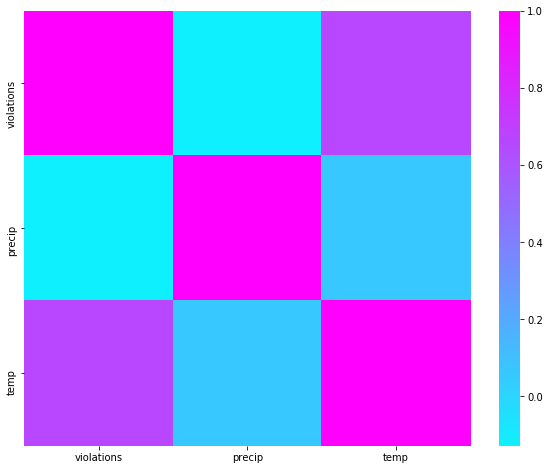

In [139]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [140]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = int_df.drop(columns=list(df_continuous.columns) + drop_me +[target])


# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [141]:
pd.options.display.max_columns = 100
df_final.head()

,violations,precip,temp,holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1704,0.00,294.15,False,0,0,0,0,0,0
1,1623,0.00,292.15,False,0,1,0,0,0,0
2,1494,6.60,295.15,False,0,0,1,0,0,0
3,1258,1.12,300.15,True,1,0,0,0,0,0
4,1366,0.00,297.15,False,0,0,0,0,1,0


In [142]:
df_final.dropna(inplace=True)

### Test train split

In [143]:
X = df_final.drop(['violations'], axis=1)
y = df_final['violations']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# pipeline = Pipeline([
#     ('std_scalar', StandardScaler())
# ])

# X_train = pipeline.fit_transform(X_train)
# X_test = pipeline.transform(X_test)

In [145]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

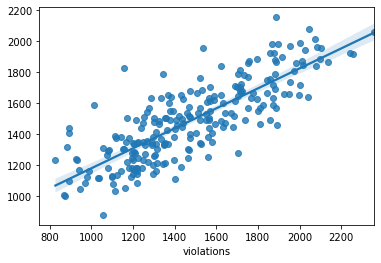

In [146]:
sns.regplot(y_test, pred)

### Plot residuals

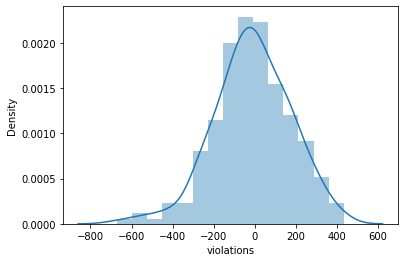

In [147]:
sns.distplot((y_test - pred), bins=15);

In [148]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 146.5066932069357
MSE: 35267.1787303342
RMSE: 187.79557697223382
R2 Square 0.6573243592823195

Train set:
MAE: 160.66561473348423
MSE: 42783.54117672398
RMSE: 206.84182646825565
R2 Square 0.6094400446825982


In [149]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,146.506693,35267.17873,187.795577,0.657324,0.593255


## Try Ridge Regression
Would like to try this since we likely have collinearity in our dataset.

In [150]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 147.2075004936809
MSE: 35681.803639719896
RMSE: 188.89627746390317
R2 Square 0.6532956316778897

Train set:
MAE: 160.510047935772
MSE: 42746.771435774666
RMSE: 206.75292364504708
R2 Square 0.6097757062007243


Ridge regression showed no improvement on original model.

In [151]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(RidgeCV(), X_train, y_train)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(ridge, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,146.506693,35267.17873,187.795577,0.657324,0.593255
1,Ridge Regression,147.207500,35681.80364,188.896277,0.653296,0.593596


In [152]:
#from sklearn.cross_validation import KFold



# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('r_squared val:', baseline)

      precip: -4.648070048246554
        temp: 19.51906087135397
     holiday: -15.387507936997403
weekday_Monday: -218.51820386527157
weekday_Saturday: 131.48113545036645
weekday_Sunday: 9.65032277120526
weekday_Thursday: -128.87791485204332
weekday_Tuesday: -225.7357845381828
weekday_Wednesday: -183.19924502379024
r_squared val: 0.6119494369802788


I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

### Result

This model looked at around 50k intersection related crashes at traffic signals.  Data is aggragated for each day. 

A linear regression was chosen, so we could better make sense of the results and see the affect of each variable.

With violations as the target, the model is vastly improved over the more noisy crash data.

Around 66% of the crashes could be explained by a model with only three variables.

##### How my variables affect violations:
- For every degree Celsius of temp change, expect an additional 19 violations.
- For weekends (Sat/Sun) expect about up to 200 additional accidents citywide over a typical weekday.
- For every 1/4" of precipitation, we can expect an 30 fewer violations citywide.
- Surprisingly, congestion has almost no affect, and is not included in this model
- Expect 15 fewer violations on holidays